In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.ensemble import IsolationForest
import matplotlib.cm as cm

In [2]:
cybersec = pd.read_excel(r".\Global_Cybersecurity_Threats.xlsx")
cybersec.head()

,Country,Year,Attack Type,Target Industry,Financial Loss (in Million $),Number of Affected Users,Attack Source,Security Vulnerability Type,Defense Mechanism Used,Incident Resolution Time (in Hours)
0,China,2019,Phishing,Education,80.53,773169.0,Hacker Group,Unpatched Software,VPN,63.0
1,China,2019,Ransomware,Retail,NaN,295961.0,Hacker Group,Unpatched Software,Firewall,71.0
2,India,2017,Man-in-the-Middle,IT,38.65,605895.0,Hacker Group,Weak Passwords,VPN,20.0
3,UK,2024,Ransomware,Telecommunications,41.44,659320.0,Nation-state,Social Engineering,AI-based Detection,7.0
4,Germany,2018,Man-in-the-Middle,IT,74.41,810682.0,NaN,Social Engineering,VPN,68.0


In [3]:
cybersec.dtypes

Country                                 object
Year                                     int64
Attack Type                             object
Target Industry                         object
Financial Loss (in Million $)          float64
Number of Affected Users               float64
Attack Source                           object
Security Vulnerability Type             object
Defense Mechanism Used                  object
Incident Resolution Time (in Hours)    float64
dtype: object

##### Correct data type

In [4]:
categorical_cols = [
    'Attack Type',
    'Target Industry',
    'Attack Source',
    'Security Vulnerability Type',
    'Defense Mechanism Used'
]
for col in categorical_cols:
    cybersec[col] = cybersec[col].astype('category')

print(cybersec.dtypes)

Country                                  object
Year                                      int64
Attack Type                            category
Target Industry                        category
Financial Loss (in Million $)           float64
Number of Affected Users                float64
Attack Source                          category
Security Vulnerability Type            category
Defense Mechanism Used                 category
Incident Resolution Time (in Hours)     float64
dtype: object


##### Check for NAs

In [5]:
missing = cybersec.isnull().sum()
print(missing)

Country                                  0
Year                                     0
Attack Type                             98
Target Industry                          0
Financial Loss (in Million $)          129
Number of Affected Users               102
Attack Source                           79
Security Vulnerability Type             77
Defense Mechanism Used                   0
Incident Resolution Time (in Hours)     76
dtype: int64


##### Conduct the Little's MCAR test 

In [6]:
from pyampute.exploration.mcar_statistical_tests import MCARTest

In [7]:
#Select columns with missing values to test
subset = cybersec[['Attack Type',
                   'Financial Loss (in Million $)',
                   'Number of Affected Users',
                   'Security Vulnerability Type',
                   'Attack Source',
                   'Incident Resolution Time (in Hours)']]
# Convert categorical variables to numerical codes
subset_encoded = subset.apply(lambda col: col.astype('category').cat.codes if col.dtypes == 'category' else col)

In [8]:
mt = MCARTest(method="little")
print(mt.little_mcar_test(subset_encoded))

0.8203963075682463


##### The p-value of the test is 0.82, so we can accept the null hypothesis. Which indicates that the missing pattern of the data is Missing Completely At Random. 

##### Because the missingness is unrelated to the data, we can simply drop all the rows with NA values.

In [9]:
cybersec_cleaned = cybersec.dropna()
cybersec_cleaned.isnull().sum()

Country                                0
Year                                   0
Attack Type                            0
Target Industry                        0
Financial Loss (in Million $)          0
Number of Affected Users               0
Attack Source                          0
Security Vulnerability Type            0
Defense Mechanism Used                 0
Incident Resolution Time (in Hours)    0
dtype: int64

##### Check for outliers

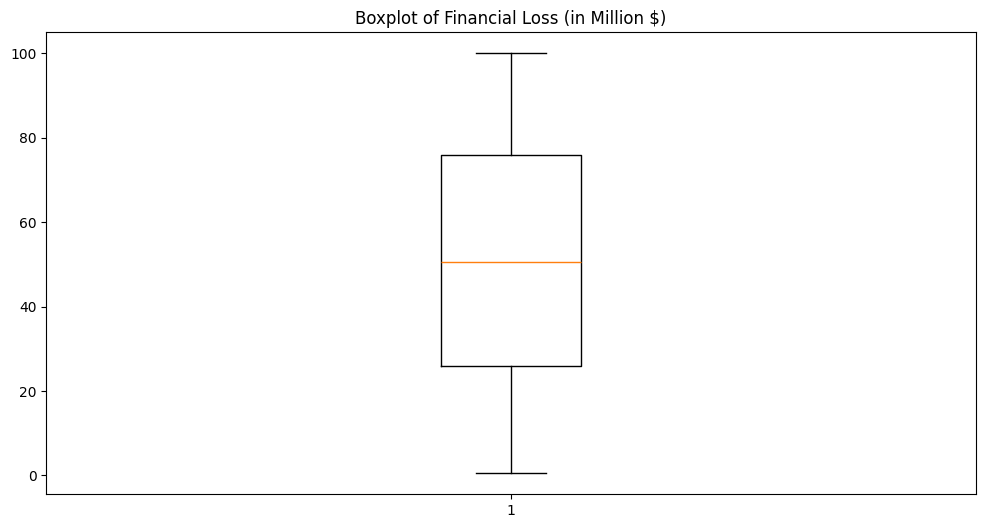

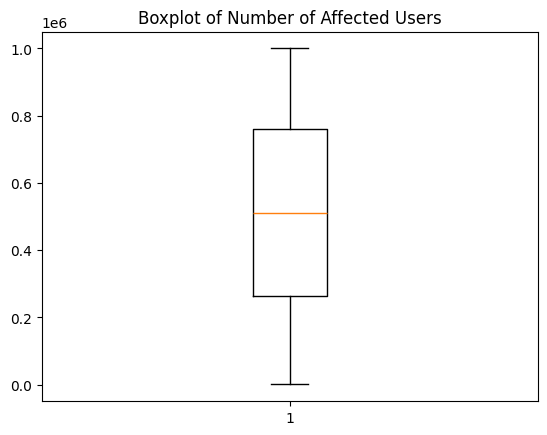

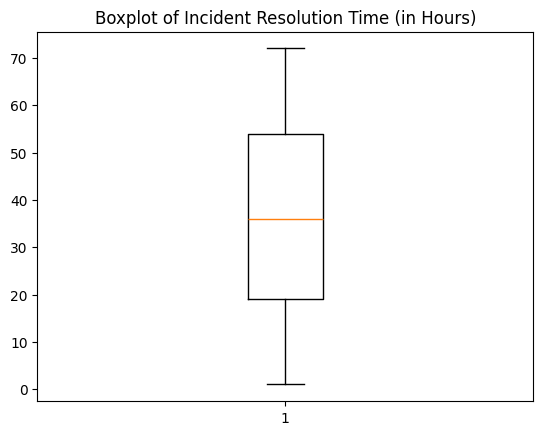

In [10]:
numeric_features = ['Financial Loss (in Million $)', 'Number of Affected Users', 'Incident Resolution Time (in Hours)']
plt.figure(figsize=(12, 6))
for feature in numeric_features:
    plt.boxplot(cybersec_cleaned[feature])
    plt.title(f'Boxplot of {feature}')
    plt.show()


**2. 📈TIME SERIES ANALYSIS**📈

**2.1. Cybersecurity Incidents Over the Years**🌐
- 2.1.1. **Chart of number of incidents overtime:**

In [11]:
incident_trends = cybersec_cleaned.groupby('Year', observed=False).size().reset_index(name='Incident Count')
x = incident_trends['Year']
y = incident_trends['Incident Count']
coef = np.polyfit(x, y, 1)
trend = np.poly1d(coef)
incident_trends['Trend'] = trend(x)

# Find peak point
max_idx = incident_trends['Incident Count'].idxmax()
max_year = incident_trends.loc[max_idx, 'Year']
max_value = incident_trends.loc[max_idx, 'Incident Count']

fig = px.line(incident_trends, x='Year', y='Incident Count',
              title='Number of Incidents Over Time',
              labels={'Year': 'Year', 'Incident Count': 'Number of Incidents'},
              markers=True)

# Insert Tendency line
fig.add_trace(go.Scatter(
    x=incident_trends['Year'],
    y=incident_trends['Trend'],
    mode='lines',
    name='Trend Line',
    line=dict(color='orange', dash='dash')
))

# Insert Peak
fig.add_trace(go.Scatter(
    x=[max_year],
    y=[max_value],
    mode='markers+text',
    name='Peak',
    marker=dict(color='red', size=10),
    text=[f"Peak: {max_value}"],
    textposition='top center'
))
fig.update_layout(title_x=0.5, xaxis=dict(tickmode='linear'), width=800, height=500)
fig.show()

👉 **Interpretation:**
- 📊Period 2015–2019:
    - Highest year: 2017 with 272 incidents.
    - Lowest year: 2019 with 221 incidents (sudden decrease).
    - Strong increase from 2016 (229) → 2017 (272). Then continuously decreased through 2018 (261) → 2019 (221).
- 📈Period 2020–2024:
    - Data fluctuates from 246 → 265 incidents. 
    - The trend is quite stable, fluctuating around the average of about 253–255.




- 2.1.2. **Using Isolation Forest to detect anomaly**: 
    - To detect anomalies such as whether there was a sudden decrease in the number of threats in 2019, we can use the Anomaly Detection method according to the time series. Here our team chose to use Isolation Forest to detect anomalies.

In [12]:
yearly_incidents = cybersec_cleaned['Year'].value_counts().sort_index()
df_incidents = pd.DataFrame({'Year': yearly_incidents.index, 'Incidents': yearly_incidents.values})

- Our data spans from 2015 to 2024, which means 10 years, corresponding to 10 data points. With n = 10, the number of points is very small, so we choose contamination = 0.1, which means that 10% of the data is assumed by the model to be abnormal. According to the graph of total incidents by year, it is easy to see that we have 1 abnormal point, which bottom in 2019. We want to make sure that it is clearly an abnormal year. So we will choose contamination = 0.1.

In [13]:
model = IsolationForest(contamination=0.1, random_state=42)
df_incidents['Anomaly'] = model.fit_predict(df_incidents[['Incidents']])
df_incidents['Anomaly_Label'] = df_incidents['Anomaly'].map({1: 'Normal', -1: 'Anomal'})
df_incidents


,Year,Incidents,Anomaly,Anomaly_Label
0,2015,234,1,Normal
1,2016,229,1,Normal
2,2017,272,1,Normal
3,2018,261,1,Normal
4,2019,221,-1,Anomal
5,2020,250,1,Normal
6,2021,250,1,Normal
7,2022,265,1,Normal
8,2023,257,1,Normal
9,2024,246,1,Normal


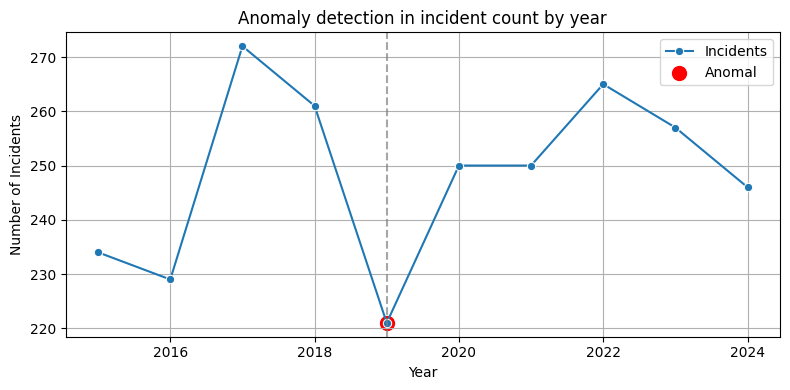

In [14]:
plt.figure(figsize=(8,4))
sns.lineplot(data=df_incidents, x='Year', y='Incidents', marker='o', label='Incidents')

# Tô đậm các điểm bất thường
anomalies = df_incidents[df_incidents['Anomaly'] == -1]
plt.scatter(anomalies['Year'], anomalies['Incidents'], color='red', s=100, label='Anomal')

plt.axvline(2019, color='gray', linestyle='--', alpha=0.7)
plt.title("Anomaly detection in incident count by year")
plt.xlabel("Year")
plt.ylabel("Number of Incidents")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- As can be seen from the model's result and the chart, the decline in 2019 has been marked as anomaly with a red dot. 2019 had a significant decrease in incidents compared to surrounding years:
    - 2018: 261
    - 2019: 221 ⬅️ sharp decrease
    - 2020: 250
- The Isolation Forest model was correct in assessing this as an anomaly.
- **"What happened in 2019 that caused the sudden decrease in threats?"**

In [15]:
# Total Incidents by Nations
country_impact = cybersec.groupby('Country')['Financial Loss (in Million $)'].sum().reset_index()

# Top 10 Nations with highest financial loss
top10 = country_impact.sort_values(by='Financial Loss (in Million $)', ascending=False).head(10)

# Choropleth Map
fig = px.choropleth(top10,
                    locations='Country',
                    locationmode='country names',
                    color='Financial Loss (in Million $)',
                    hover_name='Country',
                    color_continuous_scale='Reds',
                    title='Top 10 Countries Suffering highest Financial Losses Due to Cyber Attacks')

fig.update_geos(projection_type="natural earth")
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_7372\1500681834.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_7372\1500681834.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




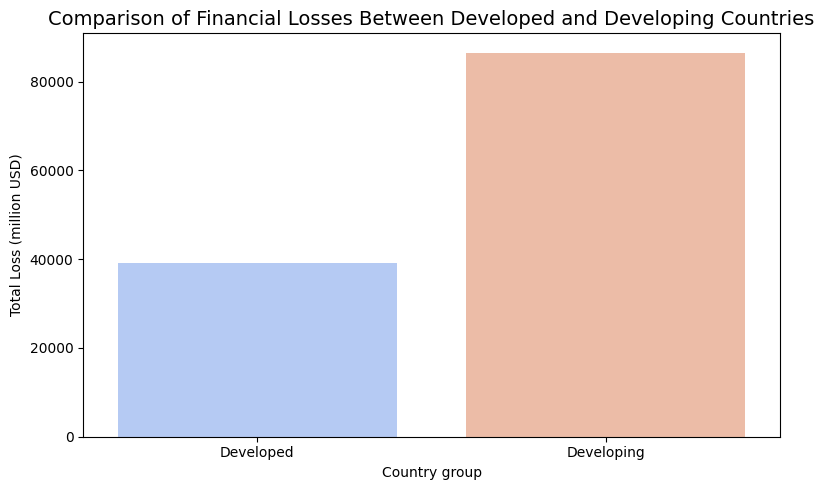

In [16]:
# Tạo danh sách quốc gia phát triển
developed_countries = ['UK', 'France', 'Japan']


# Tạo cột mới: Developed / Developing
cybersec_cleaned['Development_Status'] = cybersec_cleaned['Country'].apply(lambda x: 'Developed' if x in developed_countries else 'Developing')


# Tính tổng thiệt hại theo nhóm quốc gia
impact_by_status = cybersec_cleaned.groupby('Development_Status')['Financial Loss (in Million $)'].sum().reset_index()


# Vẽ biểu đồ so sánh
plt.figure(figsize=(8, 5))
sns.barplot(data=impact_by_status, x='Development_Status', y='Financial Loss (in Million $)', palette='coolwarm')
plt.title('Comparison of Financial Losses Between Developed and Developing Countries', fontsize=14)
plt.xlabel('Country group')
plt.ylabel('Total Loss (million USD)')
plt.tight_layout()
plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_7372\317008611.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Các ngành có trong dữ liệu: ['Education', 'IT', 'Telecommunications', 'Retail', 'Government', 'Banking', 'Healthcare']
Categories (7, object): ['Banking', 'Education', 'Government', 'Healthcare', 'IT', 'Retail', 'Telecommunications']


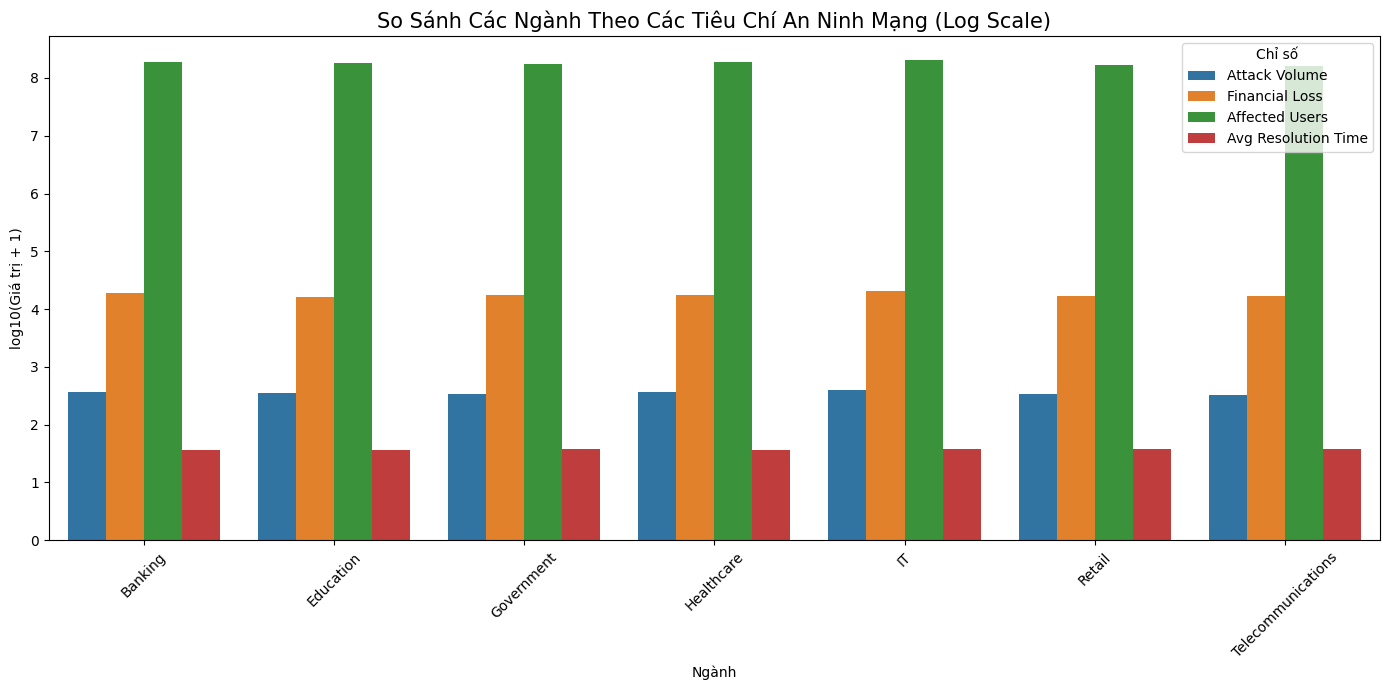

In [17]:
# Kiểm tra cột Target Industry có tồn tại không
if 'Target Industry' not in cybersec_cleaned.columns:
    print("Không tìm thấy cột 'Target Industry' trong dữ liệu!")
else:
    print("Các ngành có trong dữ liệu:", cybersec_cleaned['Target Industry'].unique())

    # Tính tổng các chỉ số theo ngành
    industry_stats = cybersec_cleaned.groupby('Target Industry').agg({
        'Financial Loss (in Million $)': 'sum',
        'Number of Affected Users': 'sum',
        'Incident Resolution Time (in Hours)': 'mean',
        'Attack Type': 'count'  # volume (số cuộc tấn công)
    }).reset_index()

    # Đổi tên cột cho dễ nhìn
    industry_stats.rename(columns={
        'Attack Type': 'Attack Volume',
        'Financial Loss (in Million $)': 'Financial Loss',
        'Number of Affected Users': 'Affected Users',
        'Incident Resolution Time (in Hours)': 'Avg Resolution Time'
    }, inplace=True)

    # Chuyển dữ liệu sang dạng "long" để vẽ grouped bar chart
    industry_melted = industry_stats.melt(id_vars='Target Industry',
                                          value_vars=['Attack Volume', 'Financial Loss', 'Affected Users', 'Avg Resolution Time'],
                                          var_name='Metric',
                                          value_name='Value')

    # Thêm cột log để xử lý lệch thang đo
    industry_melted['Log Value'] = np.log10(industry_melted['Value'] + 1)

    # Vẽ biểu đồ
    plt.figure(figsize=(14, 7))
    sns.barplot(data=industry_melted, x='Target Industry', y='Log Value', hue='Metric')
    plt.title('So Sánh Các Ngành Theo Các Tiêu Chí An Ninh Mạng (Log Scale)', fontsize=15)
    plt.xlabel('Ngành')
    plt.ylabel('log10(Giá trị + 1)')
    plt.xticks(rotation=45)
    plt.legend(title='Chỉ số')
    plt.tight_layout()
    plt.show()


C:\Users\admin\AppData\Local\Temp\ipykernel_7372\2315727120.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



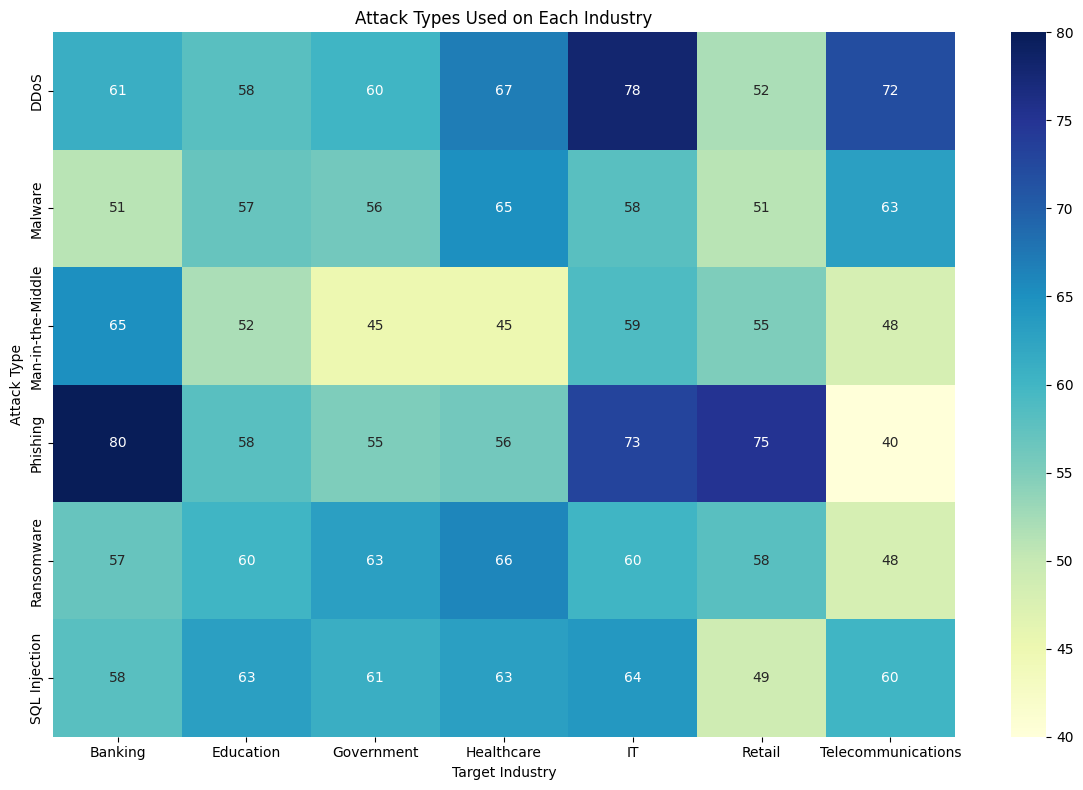

In [18]:
# Group by Attack Type and Target Industry, then count occurrences
industry_attack_counts = cybersec_cleaned.groupby(['Attack Type', 'Target Industry']).size().unstack(fill_value=0)


# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(industry_attack_counts, annot=True, fmt='d', cmap='YlGnBu')


plt.title('Attack Types Used on Each Industry')
plt.xlabel('Target Industry')
plt.ylabel('Attack Type')
plt.tight_layout()
plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_7372\498369034.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\admin\AppData\Local\Temp\ipykernel_7372\498369034.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\admin\AppData\Local\Temp\ipykernel_7372\498369034.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\admin\AppData\Local\Temp\ipykernel_7372\498369034.py:10: FutureWarning:



Passing

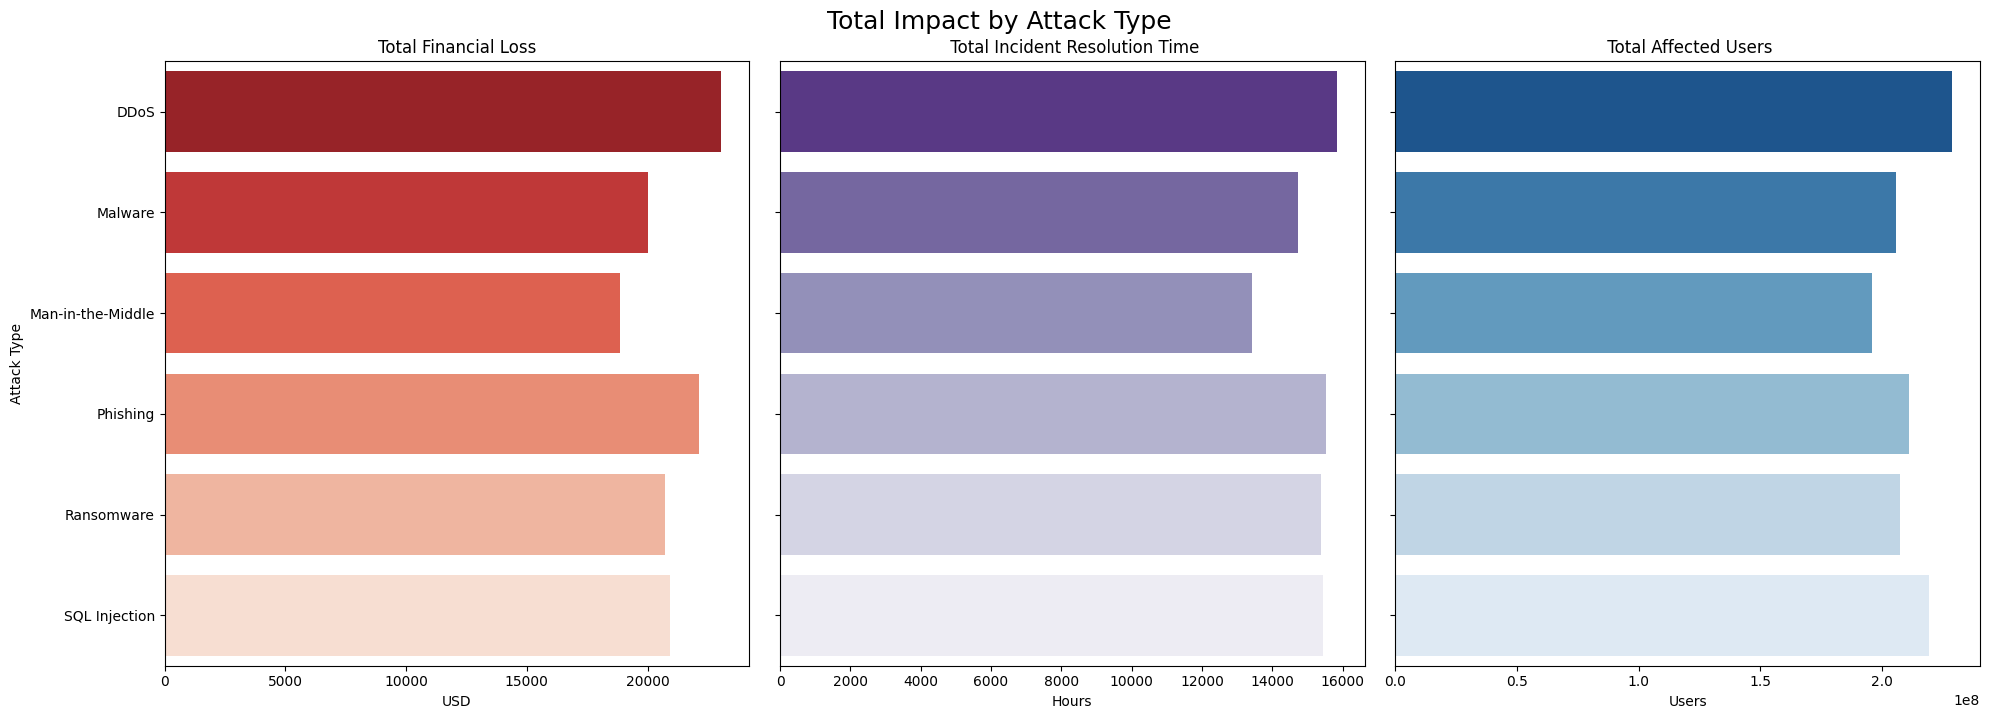

In [19]:
# Prepare data
loss_data = cybersec_cleaned.groupby("Attack Type")["Financial Loss (in Million $)"].sum().sort_values(ascending=False)
time_data = cybersec_cleaned.groupby("Attack Type")["Incident Resolution Time (in Hours)"].sum().sort_values(ascending=False)
users_data = cybersec_cleaned.groupby("Attack Type")["Number of Affected Users"].sum().sort_values(ascending=False)

# Set up the figure
fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)

# Chart 1: Financial Loss
sns.barplot(x=loss_data.values, y=loss_data.index, ax=axes[0], palette="Reds_r")
axes[0].set_title("Total Financial Loss")
axes[0].set_xlabel("USD")
axes[0].set_ylabel("Attack Type")

# Chart 2: Resolution Time
sns.barplot(x=time_data.values, y=time_data.index, ax=axes[1], palette="Purples_r")
axes[1].set_title(" Total Incident Resolution Time")
axes[1].set_xlabel("Hours")
axes[1].set_ylabel("")

# Chart 3: Affected Users
sns.barplot(x=users_data.values, y=users_data.index, ax=axes[2], palette="Blues_r")
axes[2].set_title(" Total Affected Users")
axes[2].set_xlabel("Users")
axes[2].set_ylabel("")

# Layout tweaks
plt.tight_layout()
plt.suptitle(" Total Impact by Attack Type", fontsize=18, y=1.02)
plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_7372\1571940435.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



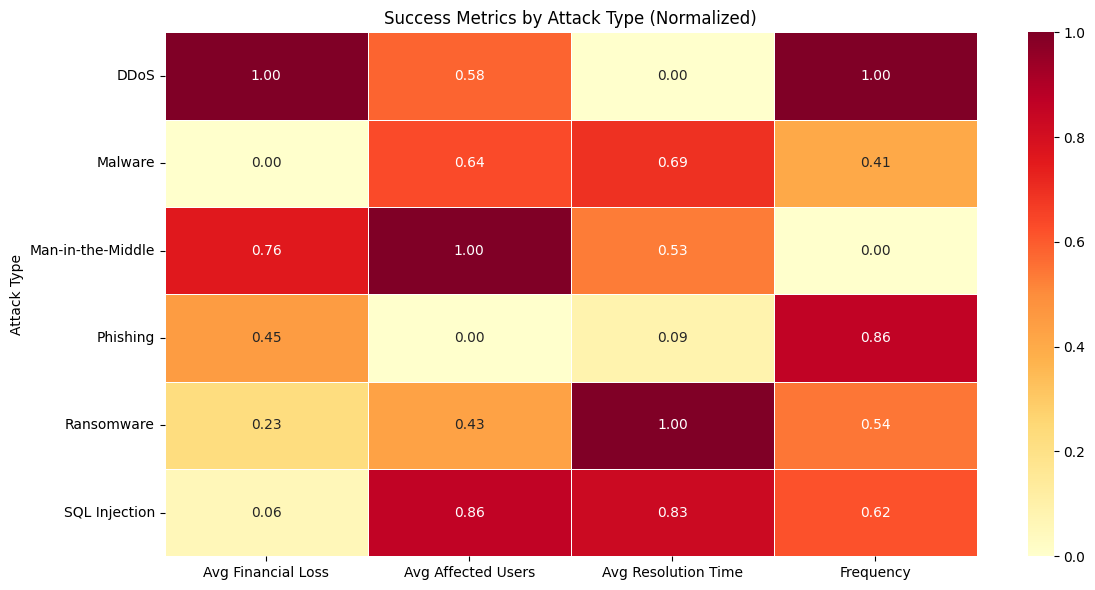

In [20]:
# Group and calculate success metrics
attack_success = cybersec_cleaned.groupby("Attack Type").agg({
    "Financial Loss (in Million $)": "mean",
    "Number of Affected Users": "mean",
    "Incident Resolution Time (in Hours)": "mean",
    "Attack Type": "count"  # Frequency
}).rename(columns={
    "Financial Loss (in Million $)": "Avg Financial Loss",
    "Number of Affected Users": "Avg Affected Users",
    "Incident Resolution Time (in Hours)": "Avg Resolution Time",
    "Attack Type": "Frequency"
})


# Normalize data for better heatmap contrast (optional)
attack_success_normalized = (attack_success - attack_success.min()) / (attack_success.max() - attack_success.min())


# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(attack_success_normalized, annot=True, cmap="YlOrRd", linewidths=0.5, fmt=".2f")
plt.title("Success Metrics by Attack Type (Normalized)")
plt.ylabel("Attack Type")
plt.tight_layout()
plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_7372\639424547.py:6: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




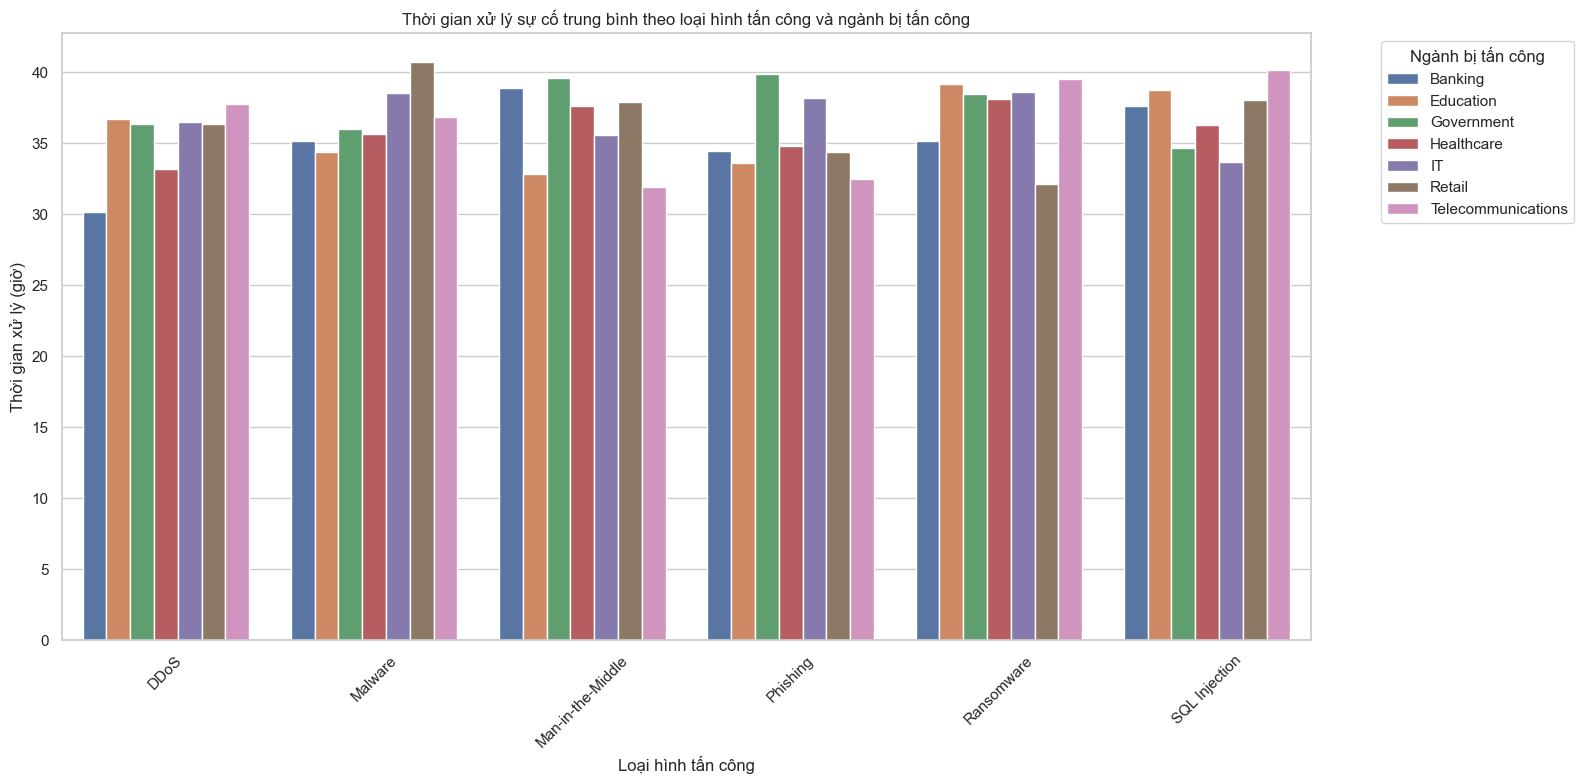

In [21]:
# Thiết lập kích thước và style
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")

# Biểu đồ barplot: Thời gian xử lý trung bình theo Attack Type và Target Industry
sns.barplot(
    data=cybersec_cleaned,
    x="Attack Type",
    y="Incident Resolution Time (in Hours)",
    hue="Target Industry",
    estimator="mean",
    ci=None
)

# Gắn tiêu đề và nhãn trục
plt.title("Thời gian xử lý sự cố trung bình theo loại hình tấn công và ngành bị tấn công")
plt.ylabel("Thời gian xử lý (giờ)")
plt.xlabel("Loại hình tấn công")
plt.xticks(rotation=45)
plt.legend(title="Ngành bị tấn công", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


C:\Users\admin\AppData\Local\Temp\ipykernel_7372\3282740756.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



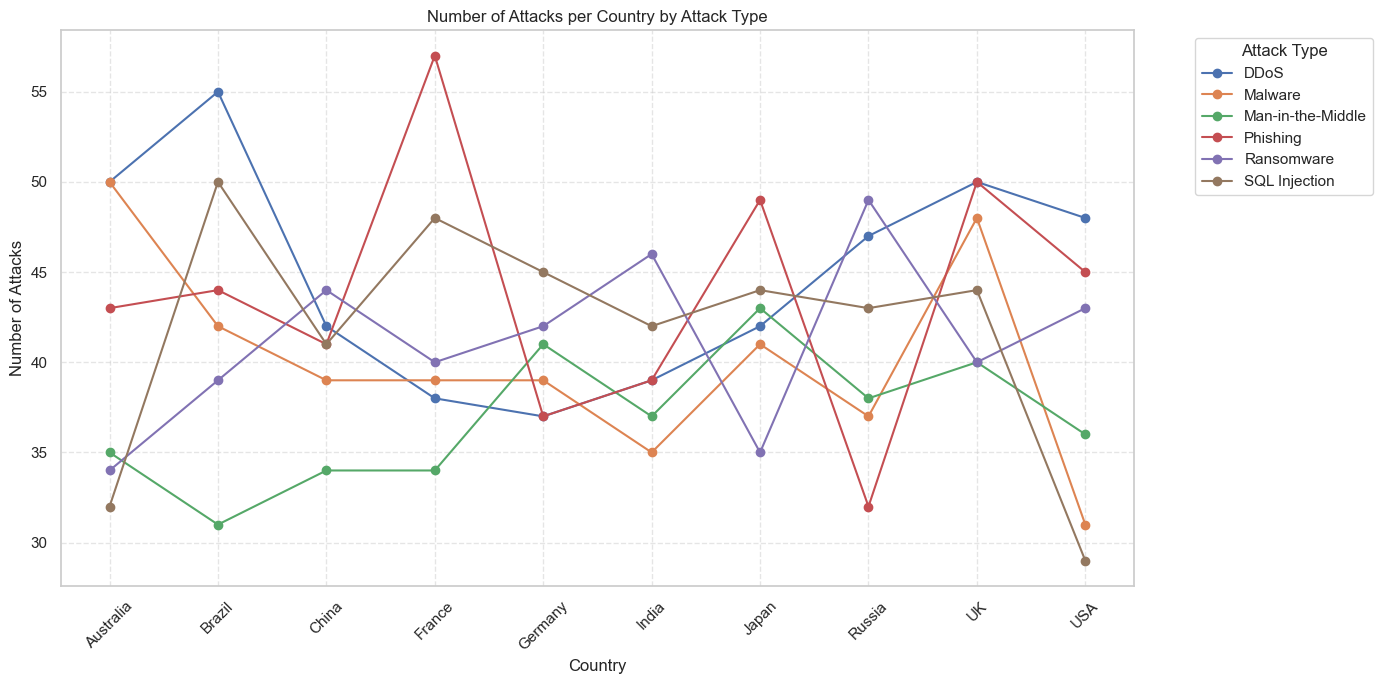

In [22]:
grouped = cybersec_cleaned.groupby(["Country", "Attack Type"]).size().reset_index(name="Attack Count")

# Pivot để tạo định dạng phù hợp cho line chart
pivot_df = grouped.pivot(index="Country", columns="Attack Type", values="Attack Count").fillna(0)

# Vẽ biểu đồ line chart
plt.figure(figsize=(14, 7))
for attack_type in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[attack_type], marker='o', label=attack_type)

plt.title("Number of Attacks per Country by Attack Type")
plt.xlabel("Country")
plt.ylabel("Number of Attacks")
plt.xticks(rotation=45)
plt.legend(title="Attack Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


C:\Users\admin\AppData\Local\Temp\ipykernel_7372\2026495826.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\admin\AppData\Local\Temp\ipykernel_7372\2026495826.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




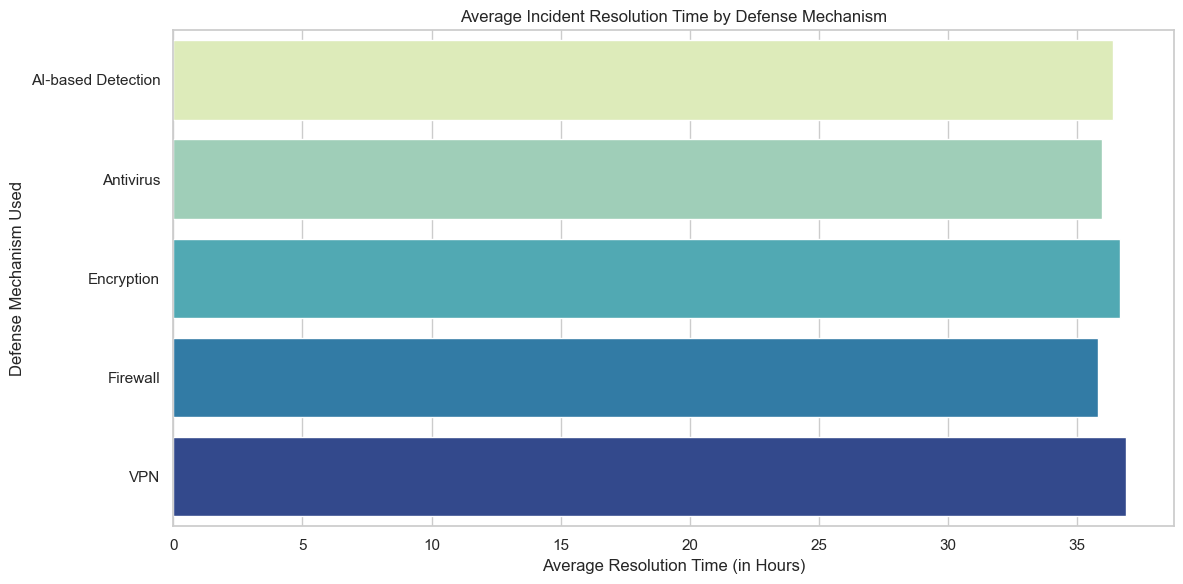

In [23]:
# Nhóm và tính trung bình thời gian xử lý theo từng cơ chế phòng thủ
grouped = cybersec_cleaned.groupby("Defense Mechanism Used")["Incident Resolution Time (in Hours)"].mean().reset_index()

# Sắp xếp để biểu đồ dễ đọc hơn
grouped = grouped.sort_values(by="Incident Resolution Time (in Hours)", ascending=False)

# Vẽ bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, x="Incident Resolution Time (in Hours)", y="Defense Mechanism Used", palette="YlGnBu")

plt.title("Average Incident Resolution Time by Defense Mechanism")
plt.xlabel("Average Resolution Time (in Hours)")
plt.ylabel("Defense Mechanism Used")
plt.tight_layout()
plt.show()




C:\Users\admin\AppData\Local\Temp\ipykernel_7372\2779176498.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\admin\AppData\Local\Temp\ipykernel_7372\2779176498.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




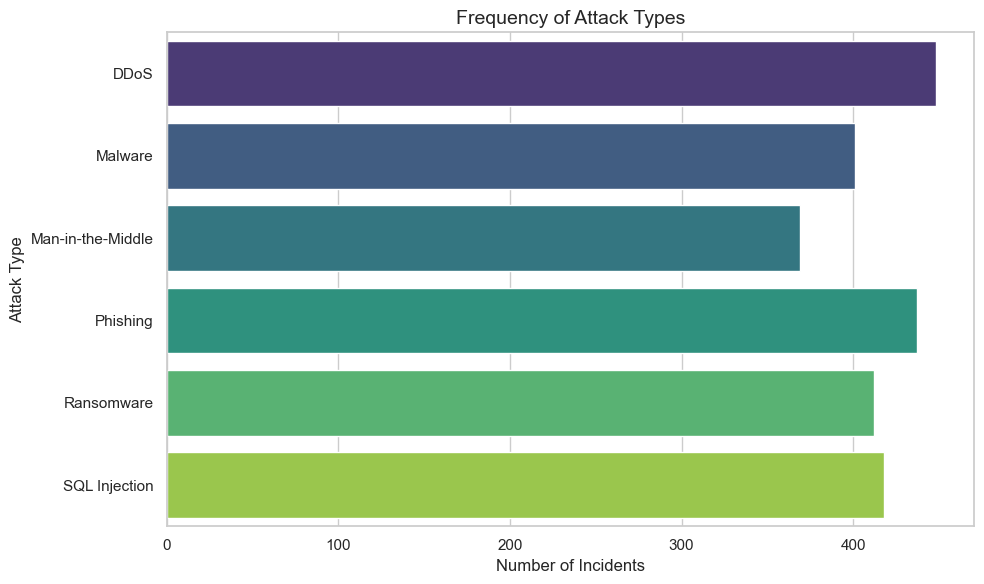

In [24]:
# Nhóm dữ liệu theo Loại Tấn Công để tính tổng số vụ tấn công
attack_type_frequency = cybersec_cleaned.groupby('Attack Type').size().reset_index(name='Number of Incidents')
# Vẽ biểu đồ cột ngang để hiển thị tần suất các loại tấn công
plt.figure(figsize=(10, 6))
sns.barplot(data=attack_type_frequency, x='Number of Incidents', y='Attack Type', palette='viridis')
plt.title('Frequency of Attack Types', fontsize=14)
plt.xlabel('Number of Incidents', fontsize=12)
plt.ylabel('Attack Type', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_7372\739215278.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



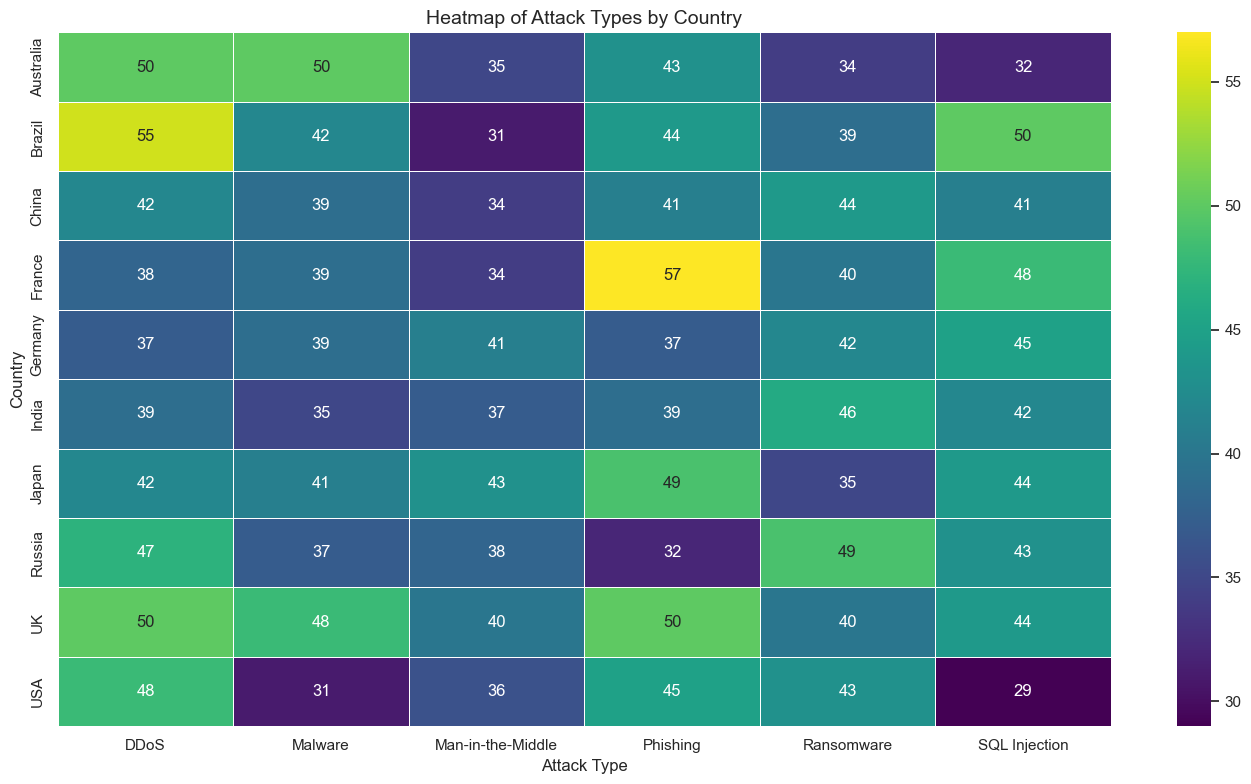

In [25]:
# Nhóm dữ liệu theo Quốc Gia và Loại Tấn Công để tính tổng số vụ tấn công
attack_by_country = cybersec_cleaned.groupby(['Country', 'Attack Type']).size().unstack(fill_value=0)

# Vẽ heatmap để hiển thị số lượng vụ tấn công theo quốc gia và loại tấn công
plt.figure(figsize=(14, 8))
sns.heatmap(attack_by_country, annot=True, fmt='d', cmap='viridis', linewidths=0.5)
plt.title('Heatmap of Attack Types by Country', fontsize=14)
plt.xlabel('Attack Type', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_7372\4136298419.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\admin\AppData\Local\Temp\ipykernel_7372\4136298419.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




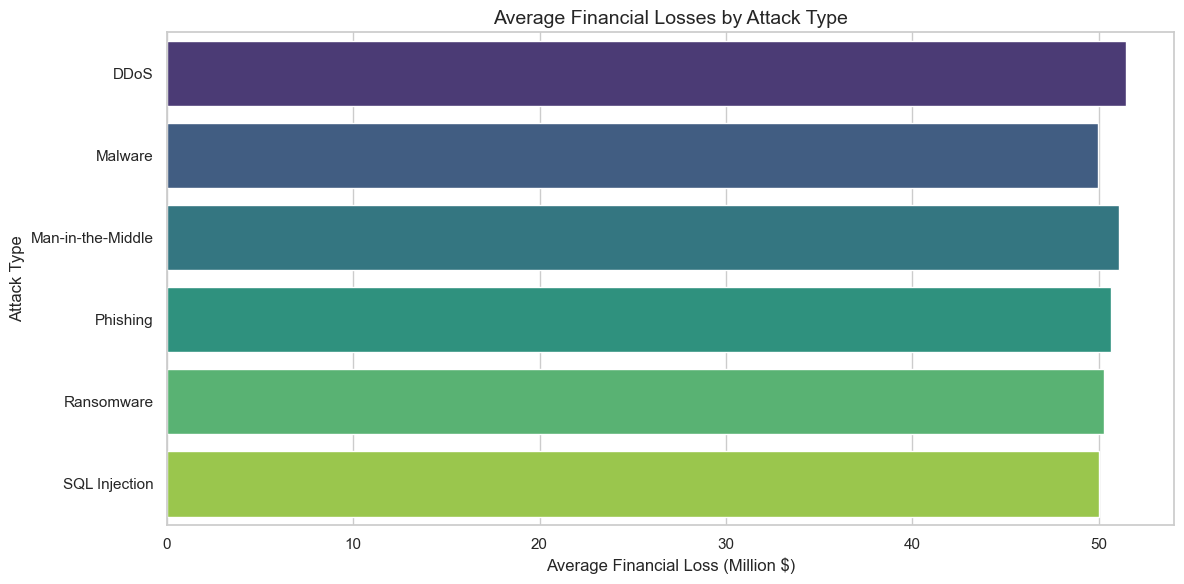

In [26]:
# Tính trung bình thiệt hại tài chính theo loại tấn công
attack_type_losses = cybersec_cleaned.groupby('Attack Type')['Financial Loss (in Million $)'].mean().reset_index()


# Sắp xếp giảm dần theo thiệt hại tài chính trung bình
attack_type_losses = attack_type_losses.sort_values(by='Financial Loss (in Million $)', ascending=False)


# Vẽ biểu đồ cột ngang để hiển thị loại tấn công gây thiệt hại tài chính trung bình cao nhất
plt.figure(figsize=(12, 6))
sns.barplot(data=attack_type_losses, x='Financial Loss (in Million $)', y='Attack Type', palette='viridis')
plt.title('Average Financial Losses by Attack Type', fontsize=14)
plt.xlabel('Average Financial Loss (Million $)', fontsize=12)
plt.ylabel('Attack Type', fontsize=12)
plt.tight_layout()
plt.show()


**2.1 Timeseries. Trend of each attack type over time**

C:\Users\admin\AppData\Local\Temp\ipykernel_7372\3893783512.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\admin\AppData\Local\Temp\ipykernel_7372\3893783512.py:10: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



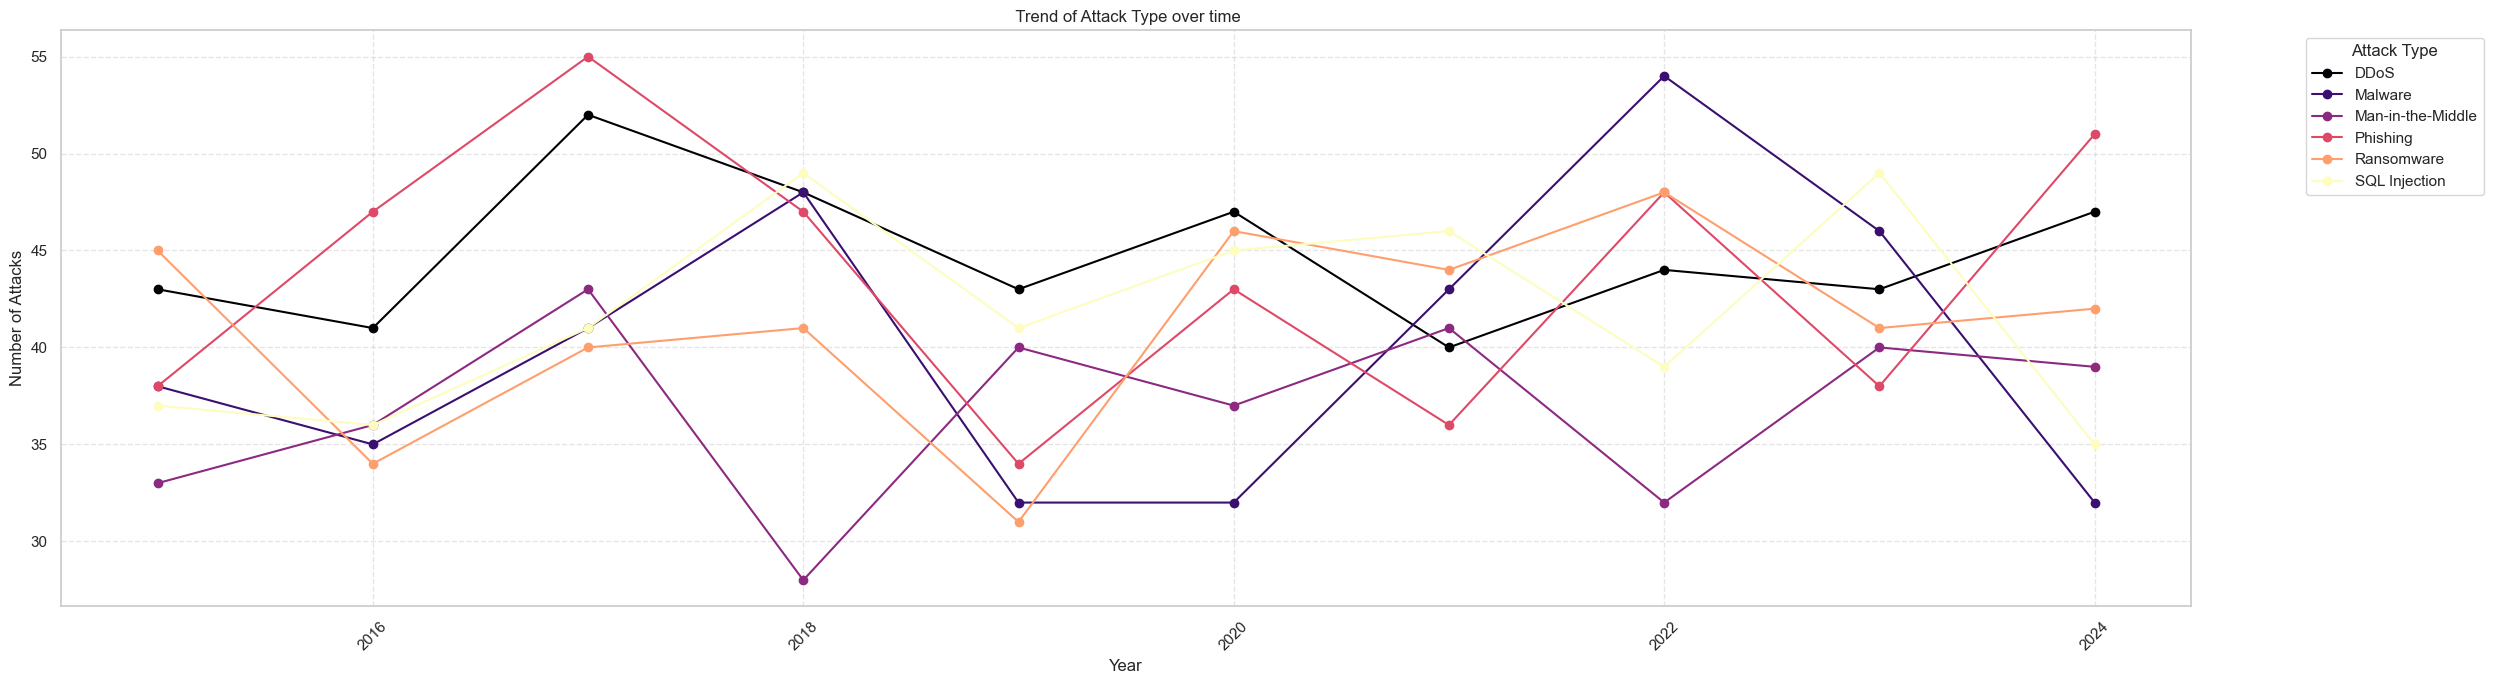

In [51]:
groupYA = cybersec_cleaned.groupby(["Year", "Attack Type"]).size().reset_index(name="Attack Count")

# Pivot để tạo định dạng phù hợp cho line chart
pivot_df = groupYA.pivot(index="Year", columns="Attack Type", values="Attack Count").fillna(0)

# Vẽ biểu đồ line chart

plt.figure(figsize=(25, 7))

colors = cm.get_cmap('magma', len(pivot_df.columns)) 

for i, attack_type in enumerate(pivot_df.columns):
    plt.plot(
        pivot_df.index,
        pivot_df[attack_type],
        marker='o',
        label=attack_type,
        color=colors(i)
    )
plt.title(" Trend of Attack Type over time")
plt.xlabel("Year")
plt.ylabel("Number of Attacks")
plt.xticks(rotation=45)
plt.legend(title="Attack Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**2.2 Timeseries. Total number of attack by Industry over time**

C:\Users\admin\AppData\Local\Temp\ipykernel_7372\3105713403.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\admin\AppData\Local\Temp\ipykernel_7372\3105713403.py:10: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



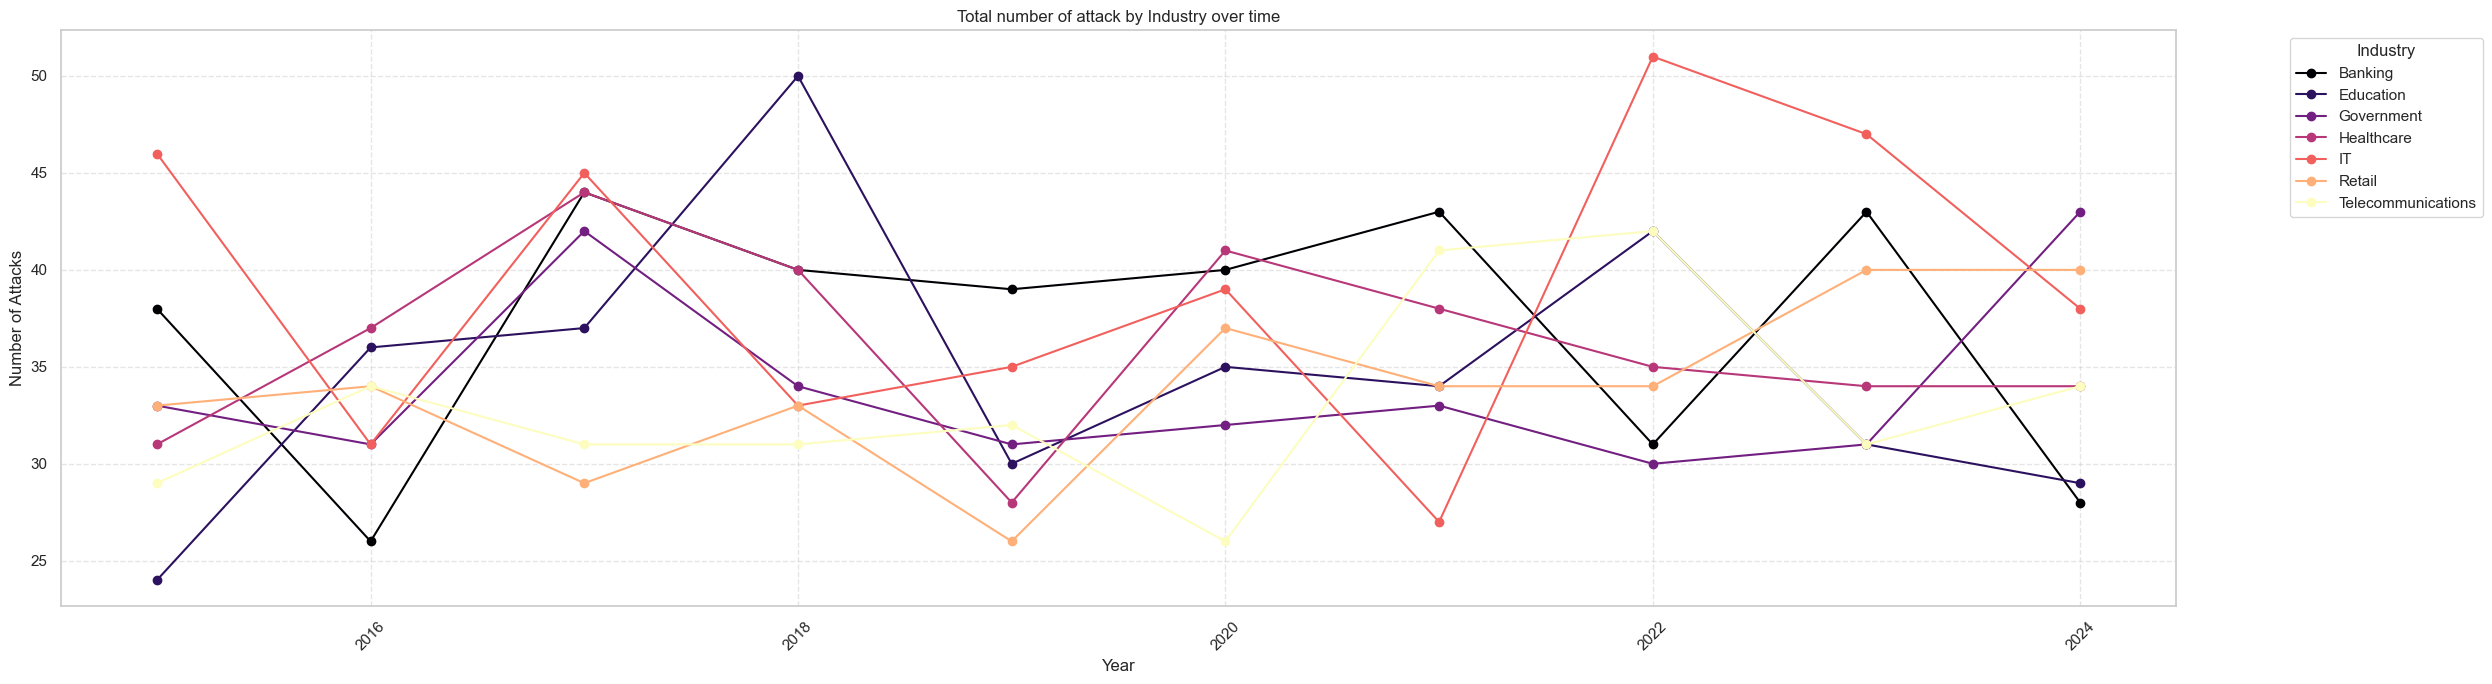

In [66]:
groupYI = cybersec_cleaned.groupby(["Year", "Target Industry"]).size().reset_index(name="Attack Count")

# Pivot để tạo định dạng phù hợp cho line chart
pivot_df = groupYI.pivot(index="Year", columns="Target Industry", values="Attack Count").fillna(0)

# Vẽ biểu đồ line chart

plt.figure(figsize=(25, 7))

colors = cm.get_cmap('magma', len(pivot_df.columns))  

for i, industry in enumerate(pivot_df.columns):
    plt.plot(
        pivot_df.index,
        pivot_df[industry],
        marker='o',
        label=industry,
        color=colors(i)
    )
plt.title("Total number of attack by Industry over time")
plt.xlabel("Year")
plt.ylabel("Number of Attacks")
plt.xticks(rotation=45)
plt.legend(title="Industry", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**2.3 Timeseries. Total financial loss on each industry over time**

C:\Users\admin\AppData\Local\Temp\ipykernel_7372\883233476.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\admin\AppData\Local\Temp\ipykernel_7372\883233476.py:10: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



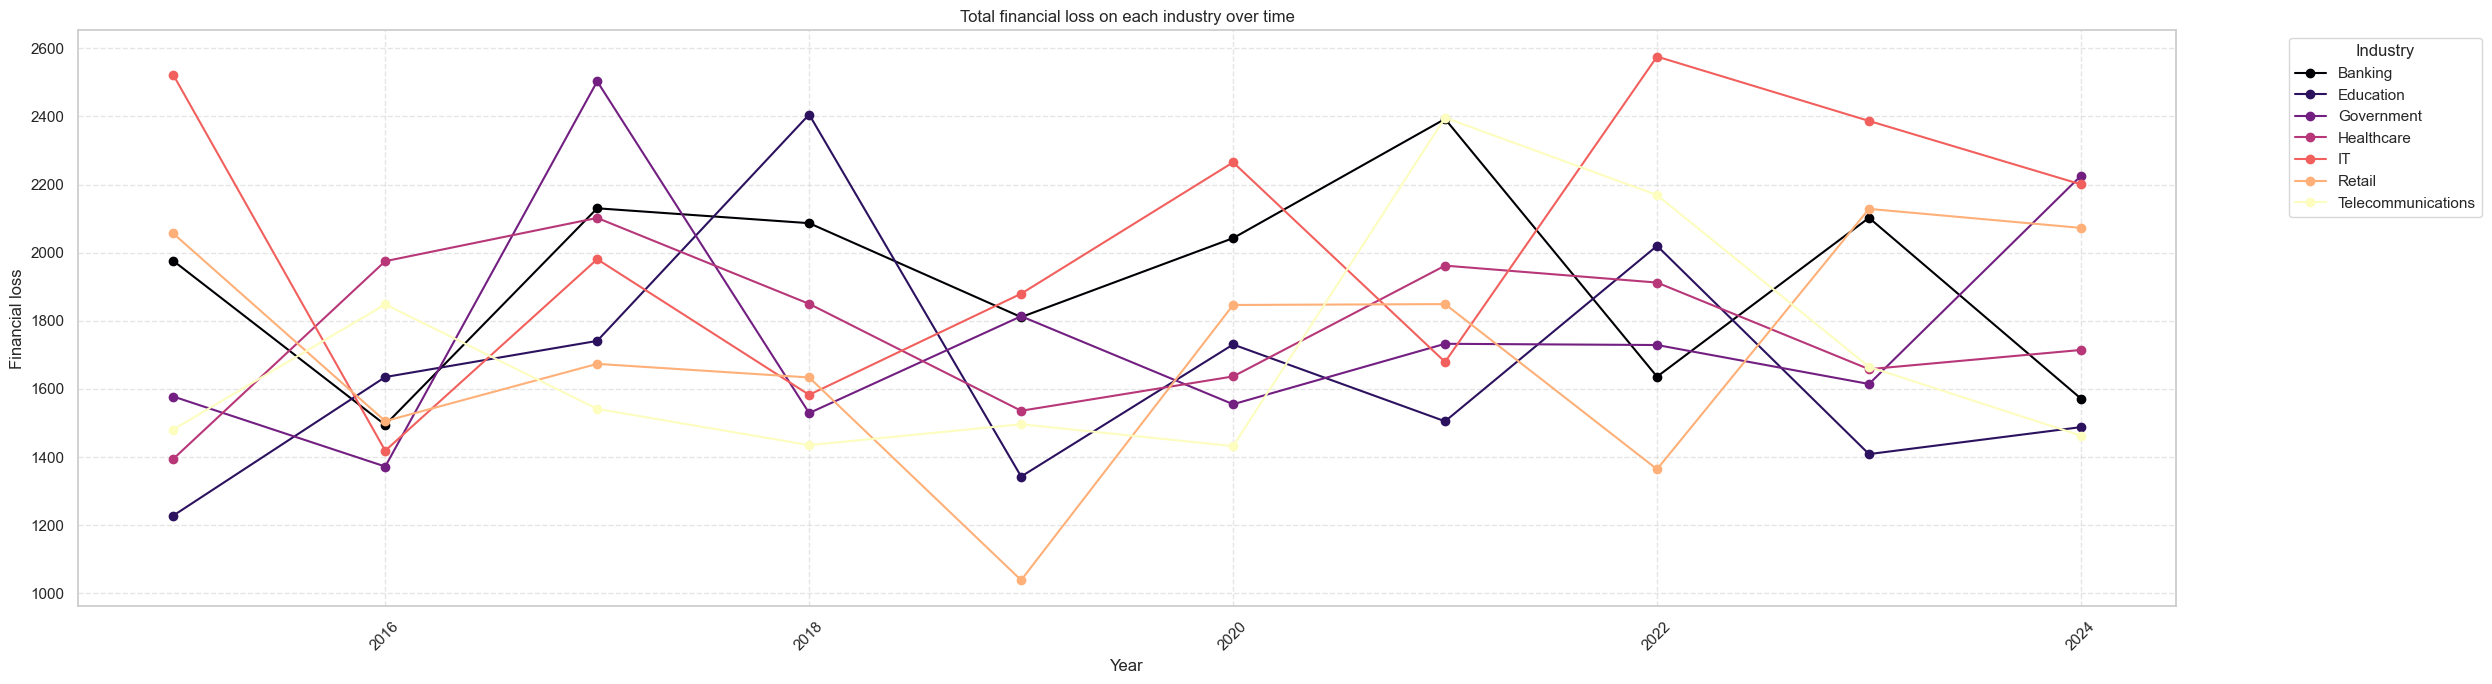

In [67]:
groupYI = cybersec_cleaned.groupby(["Year", "Target Industry"])["Financial Loss (in Million $)"].sum().reset_index(name="Financial Loss (in Million $)")

# Pivot để tạo định dạng phù hợp cho line chart
pivot_df = groupYI.pivot(index="Year", columns="Target Industry", values="Financial Loss (in Million $)").fillna(0)

# Vẽ biểu đồ line chart

plt.figure(figsize=(25, 7))

colors = cm.get_cmap('magma', len(pivot_df.columns))  

for i, industry in enumerate(pivot_df.columns):
    plt.plot(
        pivot_df.index,
        pivot_df[industry],
        marker='o',
        label=industry,
        color=colors(i)
    )
plt.title("Total financial loss on each industry over time")
plt.xlabel("Year")
plt.ylabel("Financial loss")
plt.xticks(rotation=45)
plt.legend(title="Industry", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**2.4. Proportion of financial loss by industry overtime**

C:\Users\admin\AppData\Local\Temp\ipykernel_7372\2910895142.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



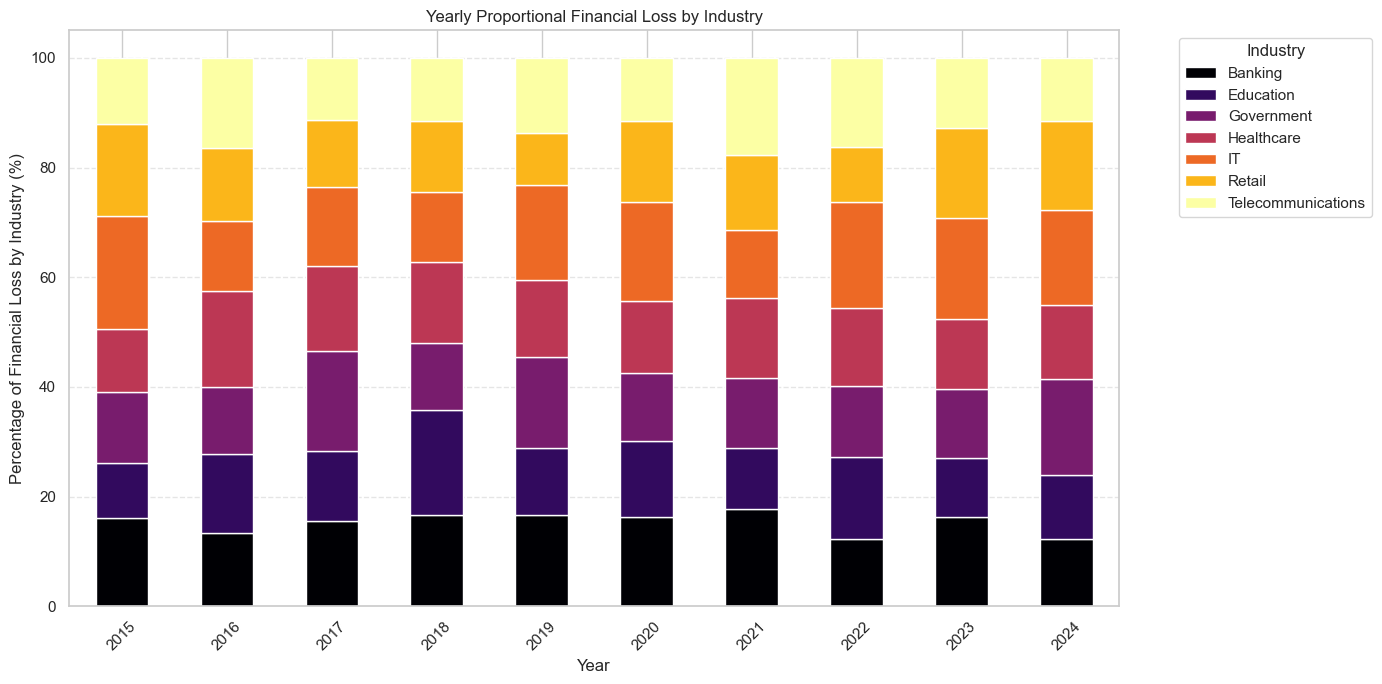

In [ ]:
#Bước 1: Gom nhóm theo Year và Target Industry
grouped = cybersec_cleaned.groupby(["Year", "Target Industry"])["Financial Loss (in Million $)"].sum().reset_index()

# Bước 2: Pivot lại thành bảng theo định dạng phù hợp
pivot = grouped.pivot(index="Year", columns="Target Industry", values="Financial Loss (in Million $)").fillna(0)

# Bước 3: Tính tỷ lệ phần trăm theo từng năm
proportional = pivot.div(pivot.sum(axis=1), axis=0) * 100  # Tỷ lệ phần trăm

# Bước 4: Vẽ stacked bar chart
proportional.plot(
    kind="bar",
    stacked=True,
    figsize=(14, 7),
    colormap="inferno"
)

plt.ylabel("Percentage of Financial Loss by Industry (%)")
plt.title("Yearly Proportional Financial Loss by Industry")
plt.xticks(rotation=45)
plt.legend(title="Industry", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

**2.5. Proportion of Defense Mechanism used by industríe**

C:\Users\admin\AppData\Local\Temp\ipykernel_7372\2036839764.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



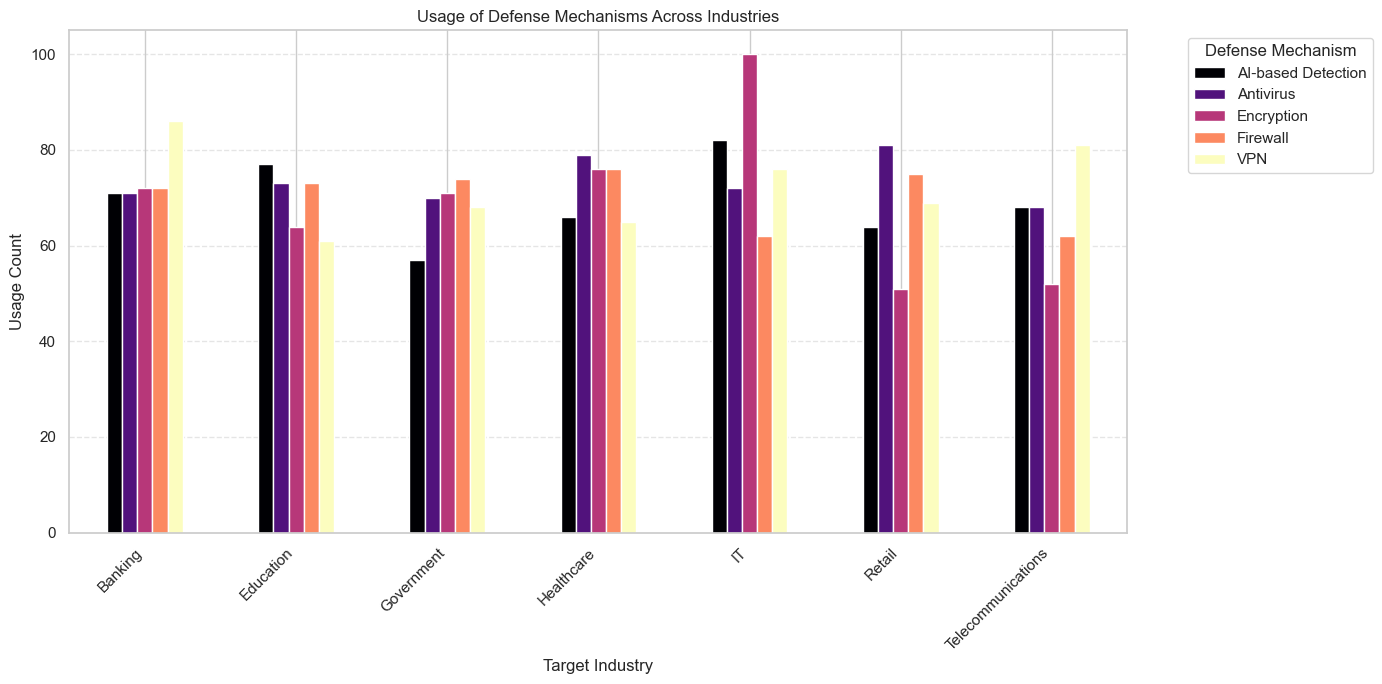

In [76]:
# Bước 1: Gom nhóm theo Target Industry và Defense Mechanism
grouped_dm = cybersec_cleaned.groupby(["Target Industry", "Defense Mechanism Used"]).size().reset_index(name="Count")

# Bước 2: Pivot để có bảng phù hợp vẽ clustered bar chart
pivot_dm = grouped_dm.pivot(index="Target Industry", columns="Defense Mechanism Used", values="Count").fillna(0)

# Bước 3: Vẽ clustered bar chart
pivot_dm.plot(
    kind='bar',
    figsize=(14, 7),
    colormap='magma' 
)

plt.title("Usage of Defense Mechanisms Across Industries")
plt.xlabel("Target Industry")
plt.ylabel("Usage Count")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Defense Mechanism", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
